In [ ]:
!pip install torchsummary

Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
              ReLU-2            [-1, 8, 32, 32]               0
         MaxPool2d-3            [-1, 8, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]           1,168
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
           Flatten-7                 [-1, 1024]               0
            Linear-8                    [-1, 8]           8,200
              ReLU-9                    [-1, 8]               0
          Dropout-10                    [-1, 8]               0
           Linear-11                   [-1, 10]              90
Total params: 9,682
Trainable params: 9,682
Non-trainable params: 0
-----------------------

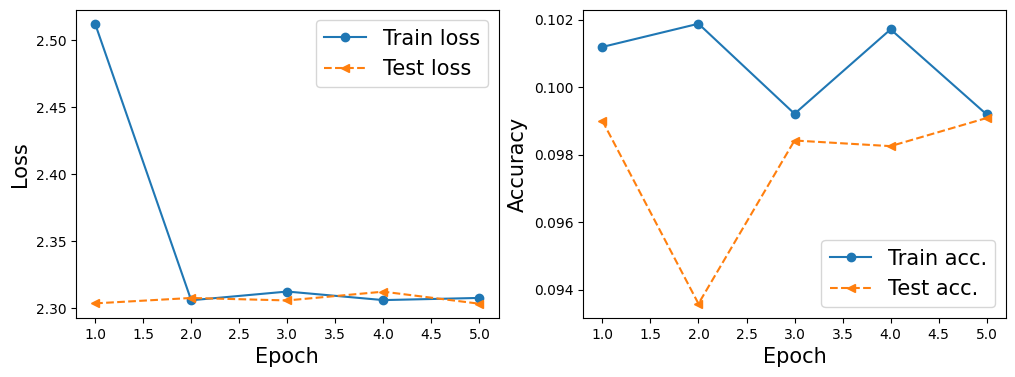

Accuracy on test set: 0.0975


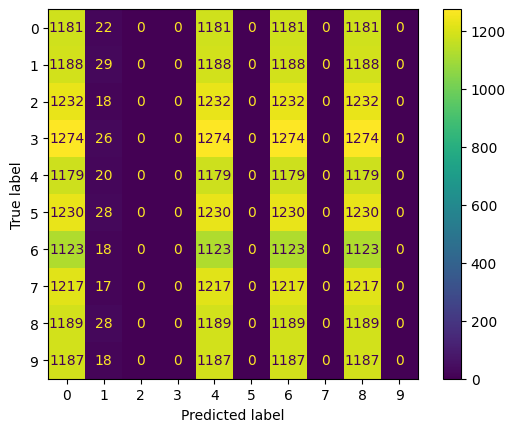

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import torchvision.datasets as datasets

def train(model, optimizer, loss_fn, num_epochs, train_dl, valid_dl):
    # lists to strore losses and accuracies
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    # main loop through epochs
    for epoch in range(num_epochs):
        # training mode
        model.train()
        for x_batch, y_batch in train_dl:
            # core of the learning process: predict and fit
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # compute train loss and accuracy
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        # compute average loss per epoch
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        # we also put the model in evaluation mode, so that specific layers such as dropout or batch normalization layers behave correctly.
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                # predict
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
                if epoch==0:
                    preds,actuals=torch.argmax(pred, dim=1),y_batch
                else:
                    preds=torch.cat((preds,torch.argmax(pred, dim=1)),dim=0)
                    actuals=torch.cat((actuals,y_batch),dim=0)
        # compute average loss per epoch
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        # print accuracy
        if (epoch+1) % 100==0:
            print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid, preds,actuals


def plot_accuracy_from_predictions(hist):
    pred=hist[4].numpy()
    actual=hist[5].numpy()
    labels = np.unique(actual)
    disp = ConfusionMatrixDisplay.from_predictions(actual,pred,labels=labels)
    # print global accuracy
    accuracy=np.sum(np.diagonal(disp.confusion_matrix))/np.sum(disp.confusion_matrix)
    print(f'Accuracy on test set: {accuracy:.4f}')
    plt.show()

def plot_losses(hist):
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Test loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Test acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

################################################################################ Data and parameters
SHOW=True # plot some images

# Parameter constants
test_size = 0.2
hidden_size = 8
batch_size = 256
num_epochs = 5
learning_rate = 0.1
regularization_param = 0.001
dropout_p = 0.1
num_classes = 10

# Transformations to CIFAR-10 
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

# Load CIFAR-10 and combine the sets 
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
data = ConcatDataset([train_data, test_data])
train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)

# Create DataLoader for training and test sets
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

###################################################################################### CNN  model
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(16 * 8 * 8, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(hidden_size, num_classes)
)

# Model description
summary(model, (3, 32, 32))  # C, H, W

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_param)

# Train the model
history = train(model, optimizer, loss_fn, num_epochs, train_dl, test_dl)

# Plot losses along epochs
plot_losses(history)

# Plot confusion matrix
plot_accuracy_from_predictions(history)
